# 2D steady flow over topography
**01 May 2023 by MiniUFO**

---

[TOC]

---

## 1. Introduction
It is well known that 2D **inviscid** and **adiabatic** shallow-water flows in terms of PV $q$:

$$
\begin{align}
\frac{d q}{d t}&=\frac{d}{dt} \left(\frac{\zeta+f}{\eta-\eta_B}\right)=\frac{d}{dt}\left( \frac{\zeta+f}{h}\right) =0\tag{1}
\end{align}
$$

have two global invariants: total (kinetic) energy $E=\int h(u^2+v^2)/2 dA$ and total enstrophy $Q=\int h q^2/2dA$.  Here $h=\eta-\eta_B$ is the fluid thickness.   [Bretherton and Haidvogel (1976)](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/twodimensional-turbulence-above-topography/839ED65E9B6684B5D6CFEFBD8108A82E) have shown that, under QG approximation, if the flow is initially given an energy $E_0$ over topography $\eta_B$, then an steady-state flow can be obtained by **minimizing** the enstrophy $Q$.  Here we are going to reproduced their steady state solution using `xinvert`.

## 2. Derivation through a variational principle
Under the QG approximations, PV can be expressed as:

$$
\begin{align}
q&\approx\frac{\zeta_g+f_0+\beta y}{D-\eta_B}\notag\\
&\approx\frac{1}{D}\left(\zeta_g+f_0+\beta y+\frac{f_0}{D}\eta_B\right)\notag\\
&=\frac{1}{D}\left(\nabla^2\psi+f_0+\beta y+\frac{f_0}{D}\eta_B\right)\tag{2}
\end{align}
$$

The second approximation is made if the variation of topography $\eta_B$ is small compared to the constant total depth $D$, that is $\eta_B\ll D$.  According to [Bretherton and Haidvogel (1976)](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/twodimensional-turbulence-above-topography/839ED65E9B6684B5D6CFEFBD8108A82E), **minimizing enstrophy** with an initial total energy $E_0$ is equivalent to a variational problem of the functional:

$$
\begin{align}
J[\psi]=Q[\psi]+\lambda (E[\psi] - E_0) \tag{3}
\end{align}
$$

where $\lambda$ is the Lagrangian multiplier.  The stationary point is obtained by taking the first variation as:

$$
\begin{align}
\delta J=\delta Q+\lambda \delta E = 0 \tag{4}
\end{align}
$$

where:

$$
\begin{align}
\delta Q&=\delta\int D\frac{1}{2}q^2 dA=\int Dq\delta q dA\notag\\
&=\int \frac{1}{D}\left(\nabla^2\psi+f_0+\beta y+\frac{f_0}{D}\eta_B\right)\delta \nabla^2\psi dA\notag\\
&=\int \frac{1}{D}\nabla^2\left(\nabla^2\psi+\frac{f_0}{D}\eta_B\right) \delta\psi dA = 0\tag{5}\\
\notag\\
\delta E &=\delta\int D\frac{1}{2}\left(\nabla\psi\right)^2dA\notag\\
&=\int D\nabla\psi\delta\left(\nabla\psi\right) dA =\int -D\nabla^2\psi\delta\psi dA \tag{6}W
\end{align}
$$

Substitute Eqs. (5-6) into Eq. (4), one gets:

$$
\begin{align}
\delta J &=\int \left[ \frac{1}{D}\nabla^2\left(\nabla^2\psi+\frac{f_0}{D}\eta_B-\lambda D \psi\right)\right]\delta\psi dA = 0  \tag{7}
\end{align}
$$

For arbitary variations of $\delta \psi$, only when:

$$
\begin{align}
\nabla^2\psi - \lambda D\psi = -\frac{f_0}{D}\eta_B  \tag{8}
\end{align}
$$

is satisfied does the steady-state flow $\psi_s$ can be found.  In this case, Eq. (8) is an elliptical equation about $\psi$ when topography $\eta_B$ is prescribed (also other constant parameters).  $\lambda$ is determined by the initial energy $E_0$ as:

$$
\begin{align}
E_0 = \int D \left(\nabla \psi_s\right)^2 dA  \tag{9}
\end{align}
$$

It is **NOT** trivial to express $\lambda$ in terms of $E_0$, but the pattern of $\psi_s$ does not change with different $E_0$ or $\lambda$ (only magnitude does).

## 3. Examples
Here we will demonstrate how to use `xinvert` python package to invert the 2D steady-state flow over topography undef QG case.  First, we generate a random topography over a rectanglar domain.


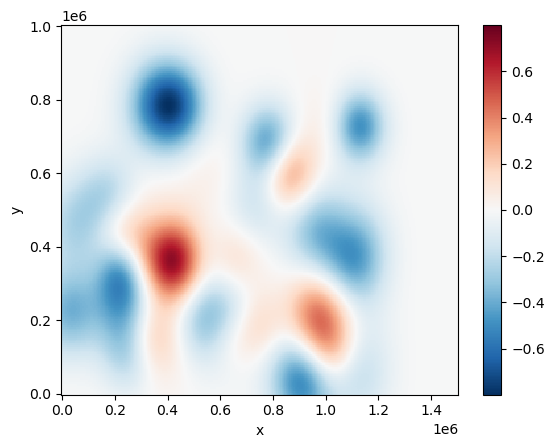

In [49]:
import numpy as np
import xarray as xr

def add_bump(topo):
    num = 50
    xpos = np.random.rand(num) * topo.x.max().values * 0.8 + 15000
    ypos = np.random.rand(num) * topo.y.max().values * 0.8 + 10000
    rads = np.random.rand(num) * 9e9 + 8e9
    amps = np.random.rand(num) - 0.5
    
    bumps = sum(amp * np.exp(-((ydef-yo)**2 + (xdef-xo)**2)/rad) for amp, xo, yo, rad in zip(amps, xpos, ypos, rads))
        
    return topo.rename('topo') + bumps

xdef = xr.DataArray(np.linspace(0, 1500000, 301), dims='x', coords={'x':np.linspace(0, 1500000, 301)})
ydef = xr.DataArray(np.linspace(0, 1000000, 201), dims='y', coords={'y':np.linspace(0, 1000000, 201)})

topo = add_bump(ydef - ydef + xdef - xdef)

topo.plot()

topo.to_netcdf('../../../Data/topo.nc')

In [1]:
### classical cases ###
import sys
sys.path.append('../../../')
import numpy as np
import xarray as xr
from xinvert import invert_BrethertonHaidvogel, cal_flow

iParams = {
    'BCs'      : ['fixed', 'fixed'],
    'mxLoop'   : 3000,
    'tolerance': 1e-16,
    'undef'    : np.nan,
}

topo = xr.open_dataset('../../../Data/topo.nc').topo

mParams1 = {'f0': 1e-4, 'D': 1000, 'lambda': 1e-14}
mParams2 = {'f0': 1e-4, 'D': 1000, 'lambda': 3e-14}
mParams3 = {'f0': 1e-4, 'D': 1000, 'lambda': 1e-13}
mParams4 = {'f0': 1e-4, 'D': 1000, 'lambda': 3e-13}

S1 = invert_BrethertonHaidvogel(topo, dims=['y','x'], coords='cartesian', mParams=mParams1, iParams=iParams)
S2 = invert_BrethertonHaidvogel(topo, dims=['y','x'], coords='cartesian', mParams=mParams2, iParams=iParams)
S3 = invert_BrethertonHaidvogel(topo, dims=['y','x'], coords='cartesian', mParams=mParams3, iParams=iParams)
S4 = invert_BrethertonHaidvogel(topo, dims=['y','x'], coords='cartesian', mParams=mParams4, iParams=iParams)

u1, v1 = cal_flow(S1, dims=['y','x'], coords='cartesian')
u2, v2 = cal_flow(S2, dims=['y','x'], coords='cartesian')
u3, v3 = cal_flow(S3, dims=['y','x'], coords='cartesian')
u4, v4 = cal_flow(S4, dims=['y','x'], coords='cartesian')

E1 = (u1**2 + v1**2).sum() / 2
E2 = (u2**2 + v2**2).sum() / 2
E3 = (u3**2 + v3**2).sum() / 2
E4 = (u4**2 + v4**2).sum() / 2

{} loops 1136 and tolerance is 0.000000e+00
{} loops 1157 and tolerance is 0.000000e+00
{} loops 1133 and tolerance is 0.000000e+00
{} loops 1116 and tolerance is 0.000000e+00


Here we choose **four sets** of parameters for the inversion, and to see how the steady state flows depends on these parameters.

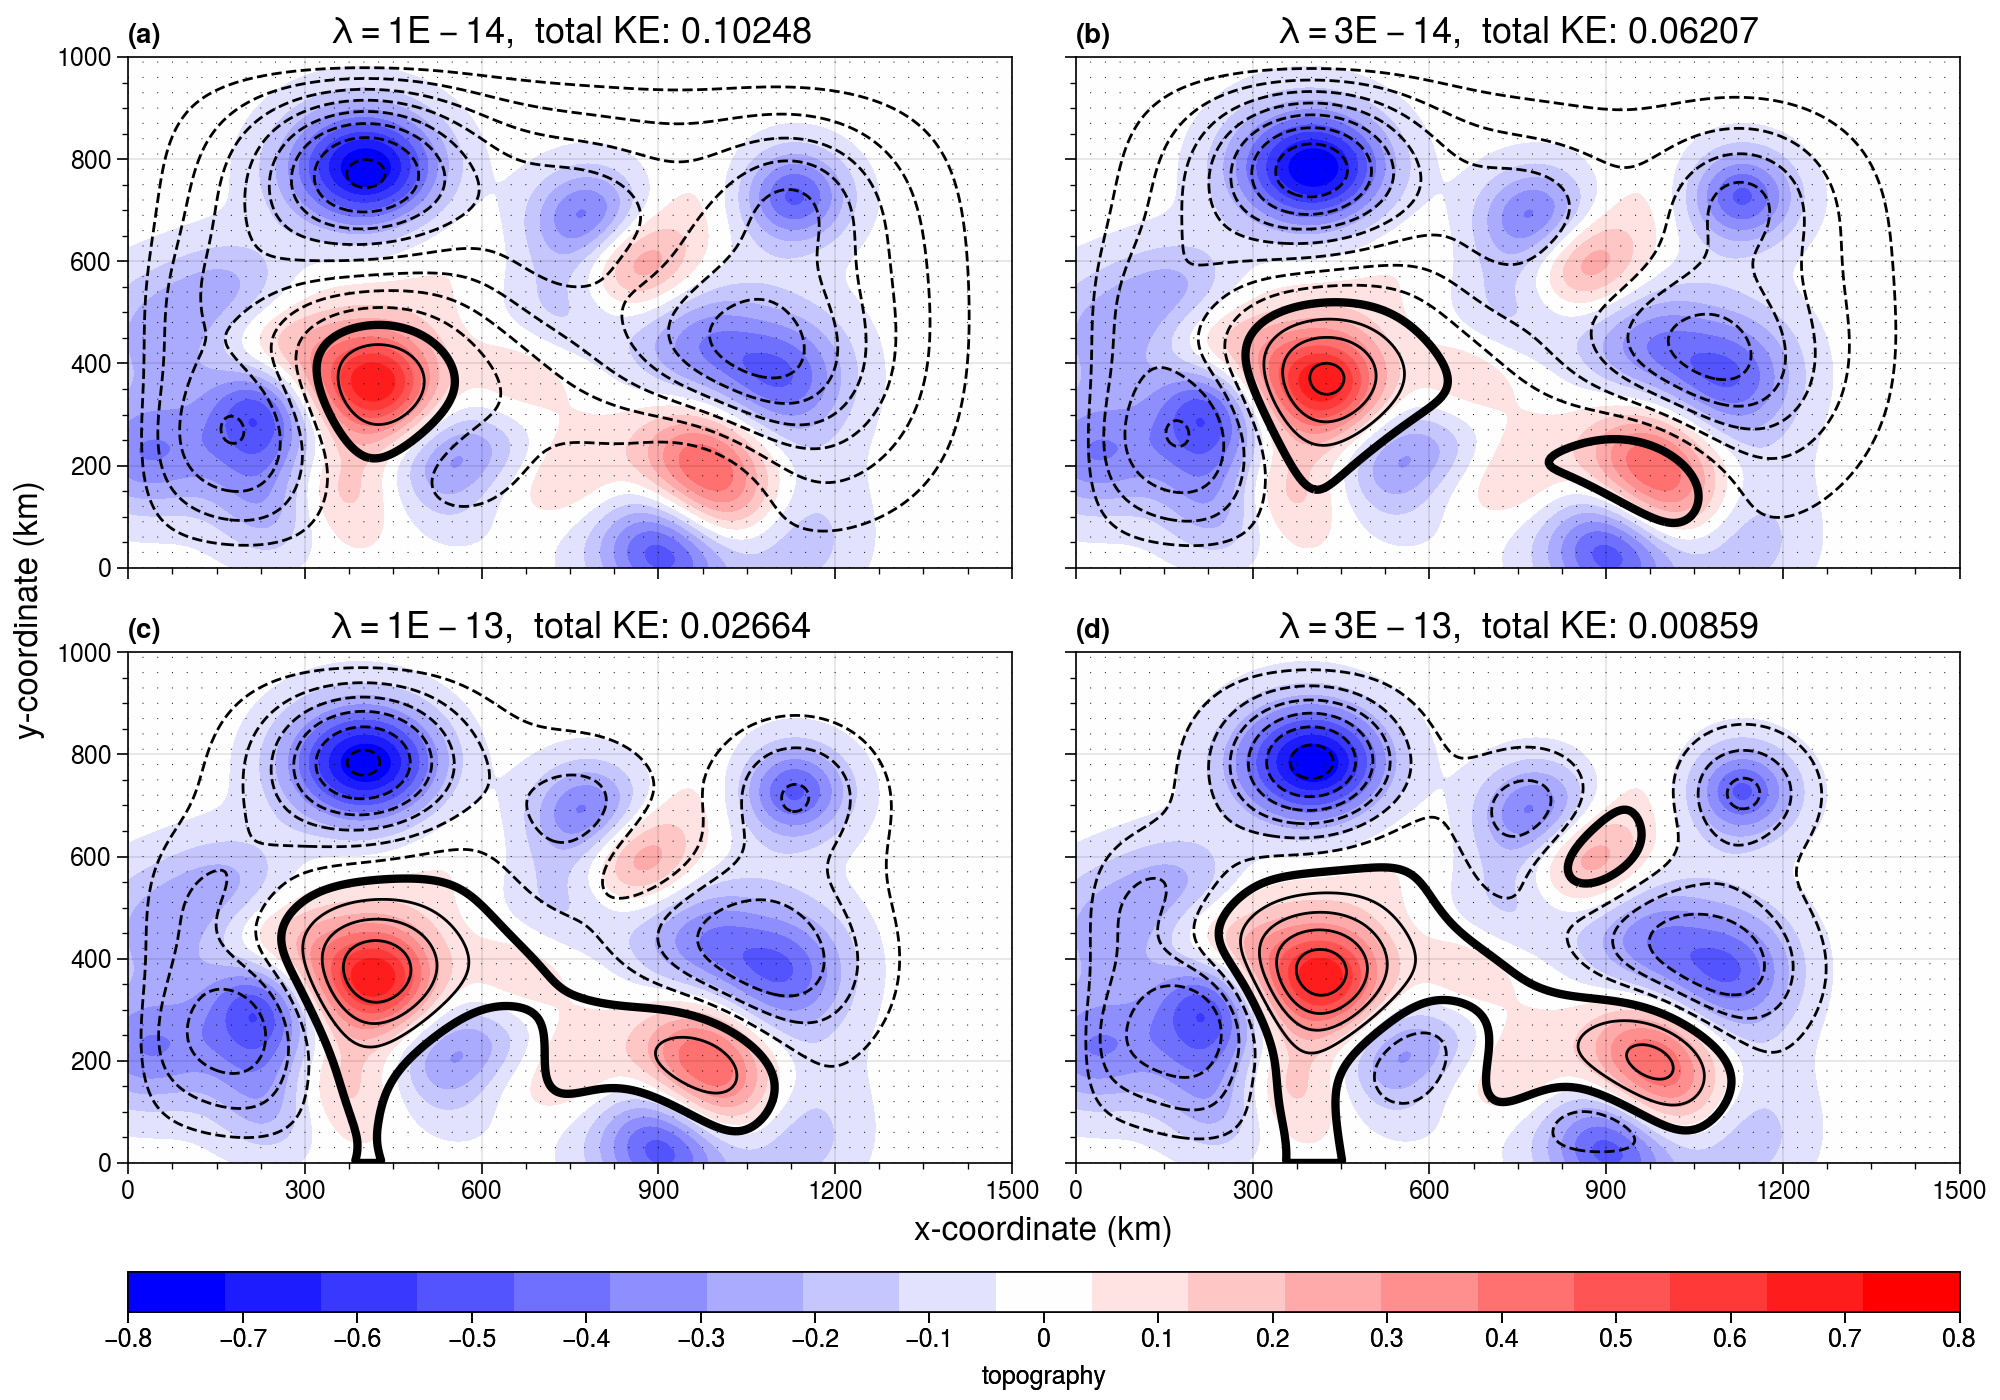

In [2]:
import proplot as pplt

skip = 5
fontsize = 13
ygrid, xgrid = xr.broadcast(topo.y, topo.x)

def plot_panel(ax, S, u, v, title, E):
    ax.contour(S, levels=11, color='k', lw=1)
    ax.contour(S, levels=[0], color='k', lw=3)
    m = ax.contourf(topo, levels=np.linspace(-0.8, 0.8, 20), cmap='bwr')
    ax.quiver(xgrid.values[::skip+1,::skip], ygrid.values[::skip+1,::skip],
              u.values[::skip+1,::skip], v.values[::skip+1,::skip],
              width=0.0014, headwidth=8., headlength=12., scale=50)
    ax.set_ylabel('y-coordinate (km)', fontsize=fontsize-1)
    ax.set_xlabel('x-coordinate (km)', fontsize=fontsize-1)
    ax.set_yticks([0, 2e5, 4e5, 6e5, 8e5, 1e6])
    ax.set_xticks([0, 3e5, 6e5, 9e5, 1.2e6, 1.5e6])
    ax.set_yticklabels(['0', '200', '400', '600', '800', '1000'])
    ax.set_xticklabels(['0', '300', '600', '900', '1200', '1500'])
    ax.set_title(title + ',  total KE: {:6.5f}'.format(E), fontsize=fontsize)
    
    return m

fig, axes = pplt.subplots(nrows=2, ncols=2, figsize=(10,7), sharex=3, sharey=3)

m = plot_panel(axes[0,0], S1, u1, v1, '$\\lambda=1E-14$', E1.values)
m = plot_panel(axes[0,1], S2, u2, v2, '$\\lambda=3E-14$', E2.values)
m = plot_panel(axes[1,0], S3, u3, v3, '$\\lambda=1E-13$', E3.values)
m = plot_panel(axes[1,1], S4, u4, v4, '$\\lambda=3E-13$', E4.values)

fig.colorbar(m, loc='b', label='topography', ticks=0.1, cols=(1,2))
axes.format(abc='(a)')

In the above plot, we show the **topography** (shaded) and **streamfunction** (contours), with flow vector superimposed.  It is clear that if the initial total KE is large, then $\lambda$ should be small.  The larger KE, the smoother the streamfunction.  This is in accordance with [Bretherton and Haidvogel (1976)](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/twodimensional-turbulence-above-topography/839ED65E9B6684B5D6CFEFBD8108A82E).  They also noted that it is not easy to get an explicit expression between $\lambda$ and $E_0$.  We can try their relation with **many** runs here.

In [3]:
lambdas = np.linspace(1e-15, 1e-12, 50)

Es = []

iParams['printInfo'] = False

for i, lm in enumerate(lambdas):
    if i % 10 == 0:
        print(i, '   ', lm)
    mParams = {'f0': 1e-4, 'D': 1000, 'lambda': lm}
    S1 = invert_BrethertonHaidvogel(topo, dims=['y','x'], coords='cartesian', mParams=mParams, iParams=iParams)
    u1, v1 = cal_flow(S1, dims=['y','x'], coords='cartesian')
    Es.append((u1**2 + v1**2).sum() / 2)

Es = np.array(Es)

0     1e-15
10     2.0487755102040815e-13
20     4.087551020408163e-13
30     6.126326530612244e-13
40     8.165102040816326e-13


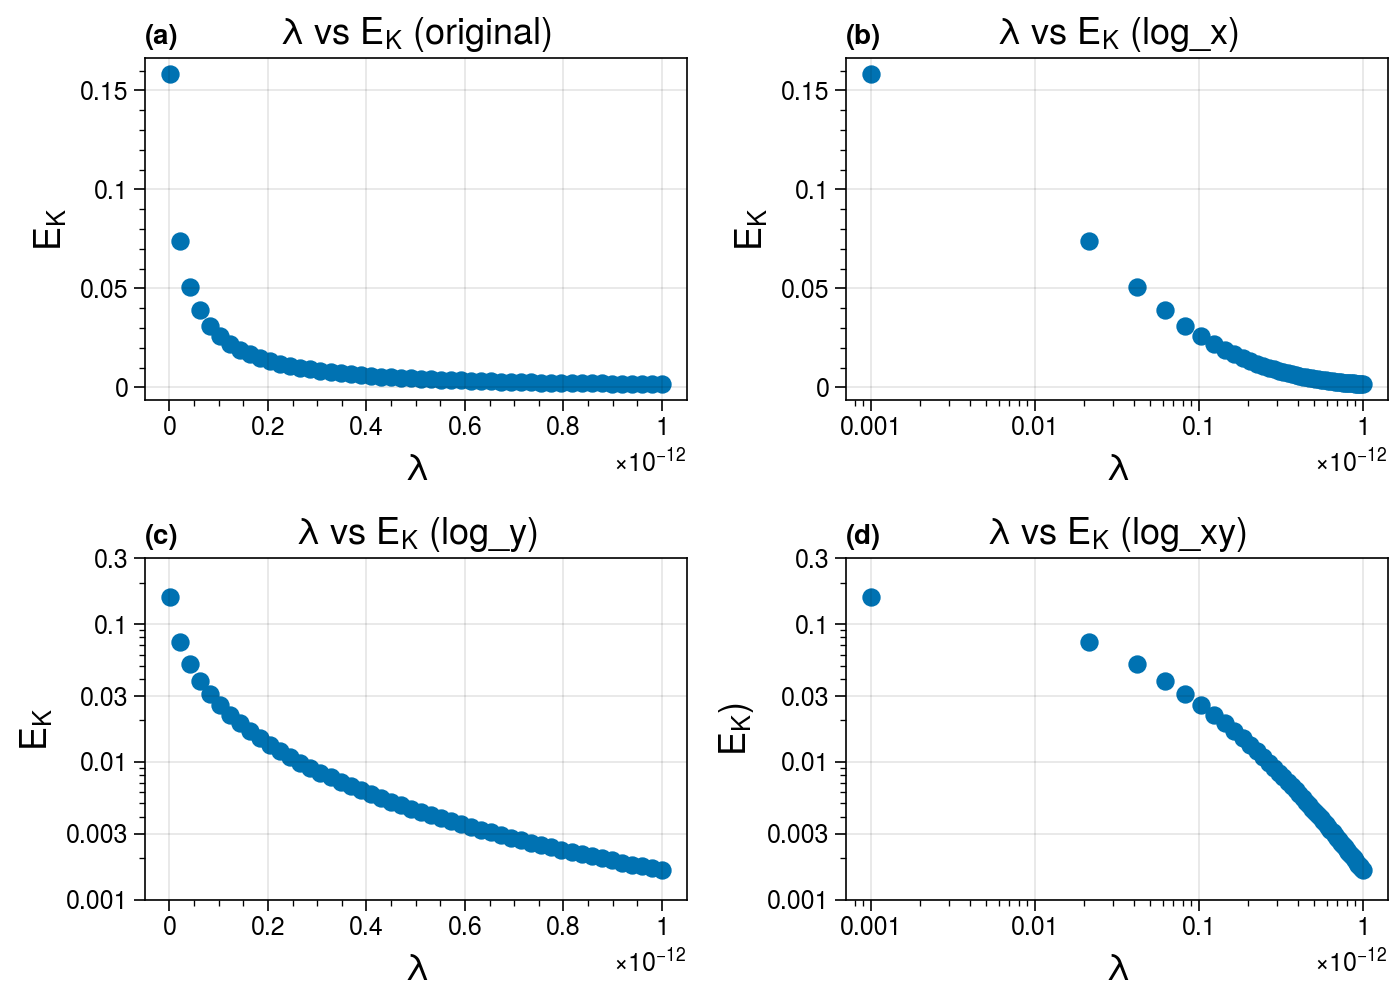

In [8]:
import proplot as pplt

fig, axes = pplt.subplots(nrows=2, ncols=2, figsize=(7,5), sharex=0, sharey=0)

fontsize = 14

ax = axes[0, 0]
ax.scatter(lambdas, Es)
ax.set_ylabel('$E_K$', fontsize=fontsize-1)
ax.set_xlabel('$\\lambda$', fontsize=fontsize-1)
ax.set_title('$\\lambda$ vs $E_K$ (original)', fontsize=fontsize-1)

ax = axes[0, 1]
ax.scatter(lambdas, Es)
ax.set_xscale('log')
ax.set_xticks(np.array([0.001, 0.01, 0.1, 1])*1e-12)
ax.set_ylabel('$E_K$', fontsize=fontsize-1)
ax.set_xlabel('$\\lambda$', fontsize=fontsize-1)
ax.set_title('$\\lambda$ vs $E_K$ (log_x)', fontsize=fontsize-1)

ax = axes[1, 0]
ax.scatter(lambdas, Es)
ax.set_yscale('log')
ax.set_yticks([1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1])
ax.set_ylabel('$E_K$', fontsize=fontsize-1)
ax.set_xlabel('$\\lambda$', fontsize=fontsize-1)
ax.set_title('$\\lambda$ vs $E_K$ (log_y)', fontsize=fontsize-1)

ax = axes[1, 1]
ax.scatter(lambdas, Es)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xticks(np.array([0.001, 0.01, 0.1, 1])*1e-12)
ax.set_yticks([1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1])
ax.set_ylabel('$E_K$)', fontsize=fontsize-1)
ax.set_xlabel('$\\lambda$', fontsize=fontsize-1)
ax.set_title('$\\lambda$ vs $E_K$ (log_xy)', fontsize=fontsize-1)

axes.format(abc='(a)')

Well, it is clear that **NO** simple relation between $K_E$ and $\lambda$.  Their relation also depends on the topography.

---

### References
1. Bretherton, F. P., and D. Haidvogel, 1976: [Two-dimensional turbulence above topography](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/twodimensional-turbulence-above-topography/839ED65E9B6684B5D6CFEFBD8108A82E). *J. Fluid Mech.*, **78**, 129-154.